<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка-данных" data-toc-modified-id="1.-Подготовка-данных-1">1. Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#2.-Анализ-и-обработка-данных" data-toc-modified-id="2.-Анализ-и-обработка-данных-2">2. Анализ и обработка данных</a></span><ul class="toc-item"><li><span><a href="#2.1-Пропуски" data-toc-modified-id="2.1-Пропуски-2.1">2.1 Пропуски</a></span></li><li><span><a href="#2.2-Анализ-данных" data-toc-modified-id="2.2-Анализ-данных-2.2">2.2 Анализ данных</a></span></li><li><span><a href="#2.3-Корреляция" data-toc-modified-id="2.3-Корреляция-2.3">2.3 Корреляция</a></span></li></ul></li><li><span><a href="#3.-Обучение-моделей" data-toc-modified-id="3.-Обучение-моделей-3">3. Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#3.1-Разделение-и-кодирование-выборок" data-toc-modified-id="3.1-Разделение-и-кодирование-выборок-3.1">3.1 Разделение и кодирование выборок</a></span></li><li><span><a href="#3.2-LightGBM" data-toc-modified-id="3.2-LightGBM-3.2">3.2 LightGBM</a></span></li><li><span><a href="#3.3-Catboost" data-toc-modified-id="3.3-Catboost-3.3">3.3 Catboost</a></span></li><li><span><a href="#3.4-Simpleboost-(ohe)" data-toc-modified-id="3.4-Simpleboost-(ohe)-3.4">3.4 Simpleboost (ohe)</a></span></li><li><span><a href="#3.5-RandomForest-(ohe)" data-toc-modified-id="3.5-RandomForest-(ohe)-3.5">3.5 RandomForest (ohe)</a></span></li><li><span><a href="#3.6-Simpleboost-(oe)" data-toc-modified-id="3.6-Simpleboost-(oe)-3.6">3.6 Simpleboost (oe)</a></span></li><li><span><a href="#3.7-RandomForest-(oe)" data-toc-modified-id="3.7-RandomForest-(oe)-3.7">3.7 RandomForest (oe)</a></span></li><li><span><a href="#3.8-ohe-vs-oe" data-toc-modified-id="3.8-ohe-vs-oe-3.8">3.8 ohe vs oe</a></span></li></ul></li><li><span><a href="#4.-Анализ-моделей" data-toc-modified-id="4.-Анализ-моделей-4">4. Анализ моделей</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

***
**Цель и задачи**

Необходимо построить модель для определения стоимости.
* Обучить разные модели. Для каждой попробовать различные гиперпараметры. (+ анализ скорости работы и качества моделей)
* Для оценки качества моделей применяем метрику `RMSE`.
* Значение метрики `RMSE` должно быть меньше `2500`.
* Изменять у модели только два-три параметра.

**Доп. задача:**
* Сравнить прямое и порядковое кодирование переменных

***
**Описание данных**

Признаки:
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак:
* `Price` — цена (евро)

## 1. Подготовка данных

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from tqdm import trange

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

RND = 2102

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('./data/autos.csv')

In [3]:
def first_check(df):
    print(df.info())
    print(f'Shape: {df.shape}')
    display(df.head())
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    display(df.describe())
    display(df.describe(include=['object', 'bool']))
    
    df_na = df.isna().sum().sort_values(ascending=False).reset_index()
    df_na['% nan'] = df_na[0] / df.shape[0] * 100
    df_na.rename(columns = {'index': 'column in df', 0 : 'amount nan'}, inplace = True)
    display(df_na)

In [4]:
first_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Количество дубликатов: 4


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


,column in df,amount nan,% nan
0,NotRepaired,71154,20.079070
1,VehicleType,37490,10.579368
2,FuelType,32895,9.282697
3,Gearbox,19833,5.596709
4,Model,19705,5.560588
5,DateCrawled,0,0.000000
6,Price,0,0.000000
7,RegistrationYear,0,0.000000
8,Power,0,0.000000
9,Kilometer,0,0.000000


### Вывод

* 354369 строк и 16 столбцов
* Присутствуют пропуски
* Минимальный год регистриции автомобиля 1000, максимальный - 9999. выделим диапозон в годах из процентилей
* Максимальная мощность автомобиля в лошадинных силах = 20 000. Показатель весьма фантастический. Выберем диапазон из процентилей.
* Много авто имееют максимальный пробег - 150000, возможно простое ограничение ввода данных на сайте.
* Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12.
* 8 типов автомобильного кузова
* Чаще встречаются авто с механической передач.
* Чаще встречаются автомобили на бензине.
* Volkswagen самая популярная марка.
* Много пропусков в столбце о ремонте авто, но чаще встречаютс автомобили без ремонта. Скорее всего владельцы пропустили это значение потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке.

## 2. Анализ и обработка данных

### 2.1 Пропуски

Для начала, приведем название столбцов в строчный регистр и уберем не нужные столбцы.

In [5]:
df.columns = map(str.lower, df.columns)
df = df.drop(['datecrawled', 'datecreated', 'registrationmonth', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

Теперь попробуем заполнить большую часть пропусков модой.

In [6]:
def fill_mode(tuple):
    # Заполнение пропусков часто встречающимися значениями
    df[tuple[0]] = df.groupby([tuple[1], tuple[2]])[tuple[0]].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [7]:
def empty_counter(column):
    # Счетчик "Empty" по столбцу
    print(f'{column} - {df[column][df[column] == "Empty"].count()}, {round(df[column][df[column] == "Empty"].count()/df.shape[0] * 100, 3)} % от датасета')

In [8]:
df['notrepaired'] = df['notrepaired'].fillna('no') # Дальше буду рассматривать пропуски, как прежде не ремонтировавшиеся

In [9]:
fill_list = [
    ('model', 'brand', 'registrationyear'),
    ('fueltype', 'brand', 'model'),
    ('vehicletype', 'brand', 'model'),
    ('gearbox', 'brand', 'model'),
]

for tuple_with_args in fill_list:
    fill_mode(tuple_with_args)

In [10]:
columns_to_check = ['model', 'fueltype', 'vehicletype', 'gearbox']

for column in columns_to_check:
    empty_counter(column)

model - 3442, 0.971 % от датасета
fueltype - 14, 0.004 % от датасета
vehicletype - 25, 0.007 % от датасета
gearbox - 21, 0.006 % от датасета


3442 объекта продажи с неизвестными моделями авто. Предлагаю их переименовать в Other. Остальные показатели малы, поэтому мы можем их удалить

In [11]:
df['model'] = df['model'].replace('Empty', 'other')

for column in columns_to_check[1:]:
    df.drop(df[df[column] == "Empty"].index, axis=0, inplace=True)

Проверим удалось ли нам избавится от пропусков

In [12]:
for column in columns_to_check:
    empty_counter(column)

model - 0, 0.0 % от датасета
fueltype - 0, 0.0 % от датасета
vehicletype - 0, 0.0 % от датасета
gearbox - 0, 0.0 % от датасета


In [13]:
df_na = df.isna().sum().sort_values(ascending=False).reset_index()
df_na['% nan'] = df_na[0] / df.shape[0] * 100
df_na.rename(columns = {'index': 'column in df', 0 : 'amount nan'}, inplace = True)
display(df_na)

,column in df,amount nan,% nan
0,price,0,0.0
1,vehicletype,0,0.0
2,registrationyear,0,0.0
3,gearbox,0,0.0
4,power,0,0.0
5,model,0,0.0
6,kilometer,0,0.0
7,fueltype,0,0.0
8,brand,0,0.0
9,notrepaired,0,0.0


### 2.2 Анализ данных

In [14]:
def make_barbplot(column, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    pivot = pd.DataFrame(df.pivot_table(index=column, aggfunc="size").sort_values(ascending=False)).head(10)
    
    sns.barplot(data=pivot, x=0, y=pivot.index)
    ax.set_title(title)
    plt.xlabel('Количество')
    plt.show()

In [15]:
def price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354343 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354343 non-null  int64 
 1   vehicletype       354343 non-null  object
 2   registrationyear  354343 non-null  int64 
 3   gearbox           354343 non-null  object
 4   power             354343 non-null  int64 
 5   model             354343 non-null  object
 6   kilometer         354343 non-null  int64 
 7   fueltype          354343 non-null  object
 8   brand             354343 non-null  object
 9   notrepaired       354343 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


**Категориальные признаки**

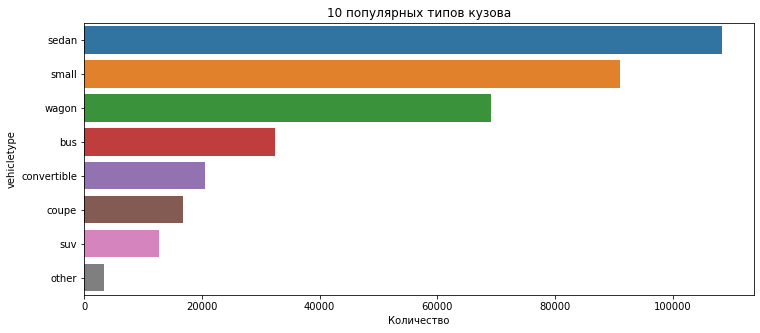

In [17]:
make_barbplot('vehicletype', '10 популярных типов кузова')

Самый популярный тип автомобильного кузова - `sedan`.

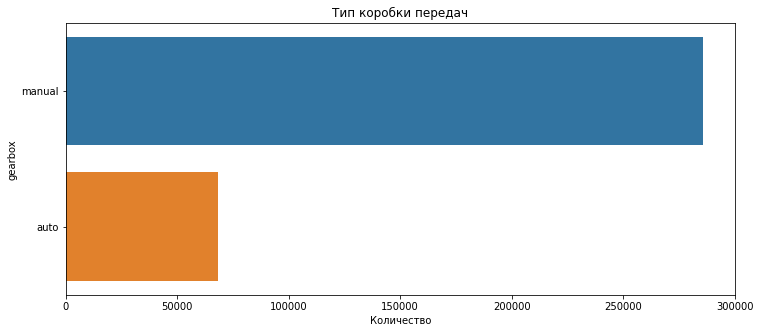

In [18]:
make_barbplot('gearbox', 'Тип коробки передач')

Большинство предпочитает механическую коробку передач.

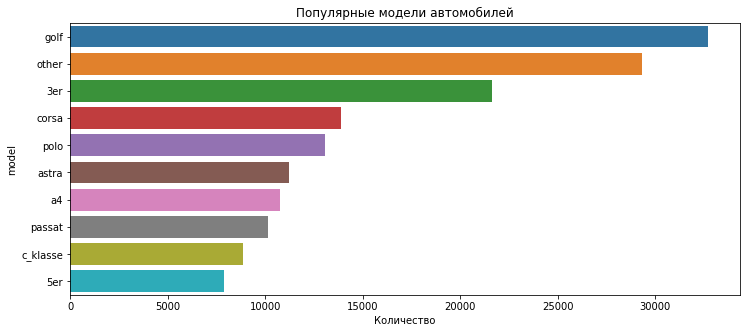

In [19]:
make_barbplot('model', 'Популярные модели автомобилей')

Самая популярная модель авто - `golf`, также заметим, что у нас много неизвестных нам моделей. (`other`)

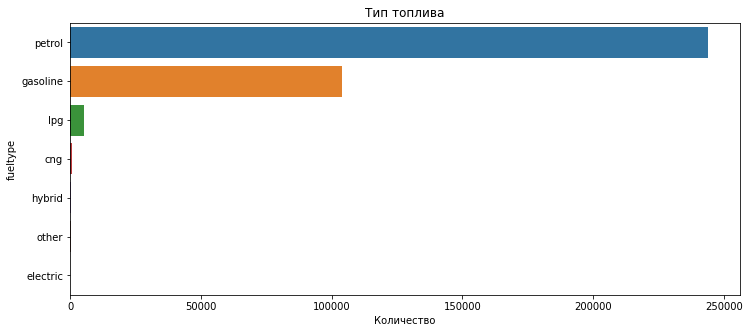

In [20]:
make_barbplot('fueltype', 'Тип топлива')

Большинство авто на бензине.

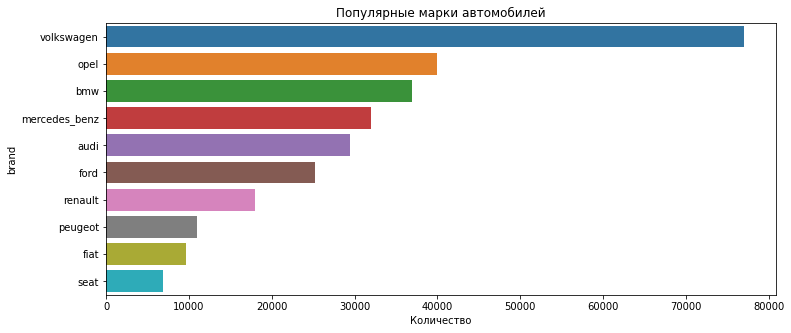

In [21]:
make_barbplot('brand', 'Популярные марки автомобилей')

Самая популярная марка Volkswagen.

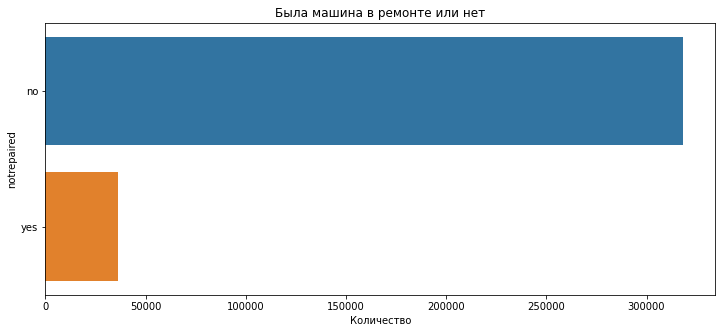

In [22]:
make_barbplot('notrepaired', 'Была машина в ремонте или нет')

Большинство авто не было в ремонте. (либо скрыли эту информацию)

**Количественные признаки**

Из пункта 1 нам известно, что имеются случаи бессплатных автомобилей, необходимо посмотреть какое кол-во авто отдают беспплатно.

In [23]:
free_cars = df.query('price == 0')
free_cars.shape

(10763, 10)

У нас 10772 бесплатных автомобиля. Похоже на ошибку при выгрузке данных или владельцы не хотели озвучивать цену транспортного средства. В любом случае нам придется убрать такие случаи из датасета.

In [24]:
df = df.query('price != 0')

Теперь посмотрим на мощность (`power`) продаваемых автомобилей.

count    343580.000000
mean        110.994121
std         188.137430
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         105.000000
55%         110.000000
60%         116.000000
65%         125.000000
70%         136.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         180.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64


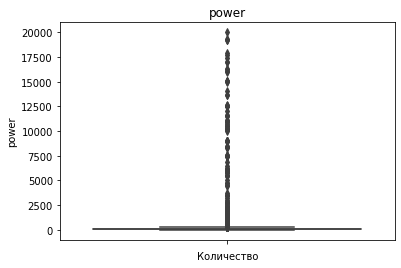

In [25]:
perc = np.arange(0,1,0.05)
print(df['power'].describe(percentiles = perc))

sns.boxplot(y='power', data=df)
plt.title('power')
plt.xlabel('Количество')
plt.show()

В данном столбце много выбросов, поэтому график становится неинформативным.

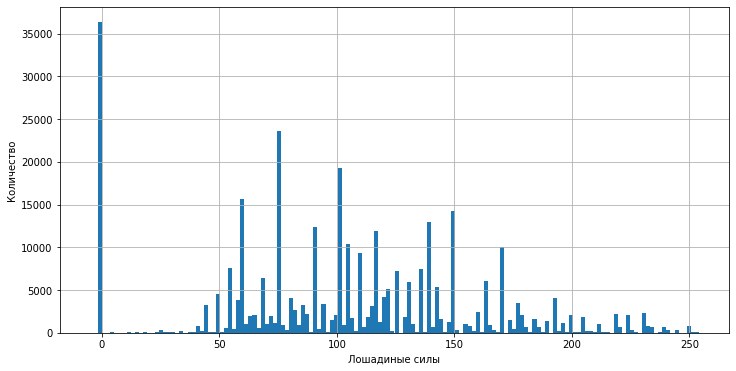

In [26]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1

df['power'].plot(kind = 'hist', bins = 150, grid=True, range=(Q1 - IQR, Q3 + 1.5 * IQR), figsize=(12, 6))
plt.xlabel('Лошадиные силы')
plt.ylabel('Количество')
plt.show()

Мы взяли квантили от показателей столбца для графика, и судя по нему в основном встречаются авто с мощностью до 250 лс. Примем 300 лс (возьму с небольшим запасом) как максимум диапазона, а нули заменим на медианы относительно групп моделей объектов.

In [27]:
medians  = df.groupby('model')['power'].median().to_dict()

def fill_median (row):
    if row['power'] == 0:
        return int(medians[row['model']])
    return int(row['power'])

In [28]:
df['power'] = df.apply(lambda row: fill_median(row), axis = 1)
df = df.query('power <= 300')

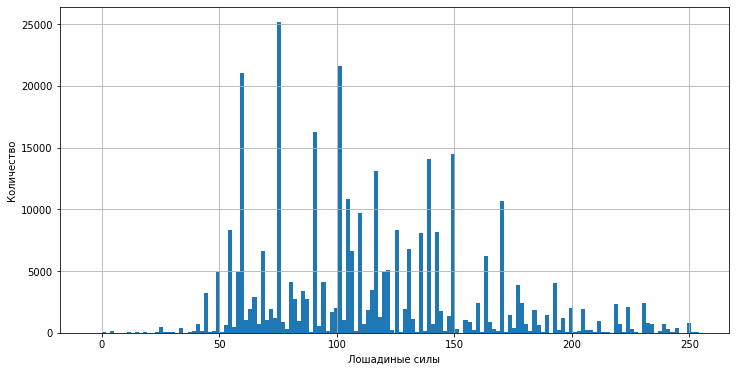

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
df['power'].plot(kind = 'hist', bins = 150, grid=True, range=(Q1 - IQR, Q3 + 1.5 * IQR), figsize=(12, 6))
plt.xlabel('Лошадиные силы')
plt.ylabel('Количество')
plt.show()

Убрали выбросы и нули из столбца `power`.

count    340132.000000
mean       2004.020127
std          74.901454
min        1000.000000
0%         1000.000000
5%         1993.000000
10%        1996.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2006.000000
70%        2007.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registrationyear, dtype: float64


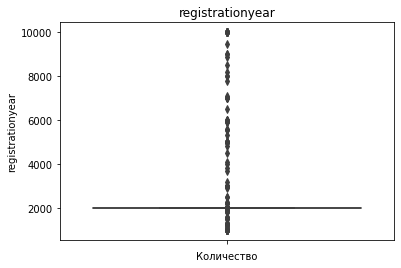

In [30]:
print(df['registrationyear'].describe(percentiles = perc))

sns.boxplot(y='registrationyear', data=df)
plt.title('registrationyear')
plt.xlabel('Количество')
plt.show()

Буду рассматривать записи с `1992` по `2020`.

In [31]:
df = df.query('registrationyear >= 1992 and registrationyear < 2020')

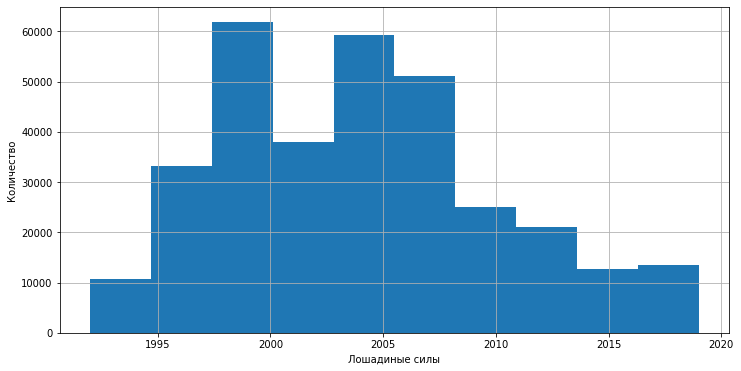

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
df['registrationyear'].plot(kind = 'hist', grid=True, figsize=(12, 6))
plt.xlabel('Лошадиные силы')
plt.ylabel('Количество')
plt.show()

Теперь проверим датасет на дубликаты.

In [33]:
df.duplicated().sum()

57497

In [34]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'Мы будем использовать {round(df.shape[0] / 354369 * 100, 3)}% от начальной выборки')

Мы будем использовать 75.827% от начальной выборки


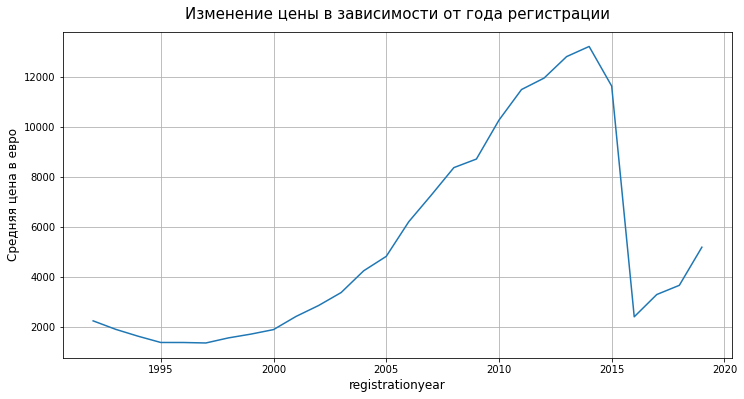

In [35]:
price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

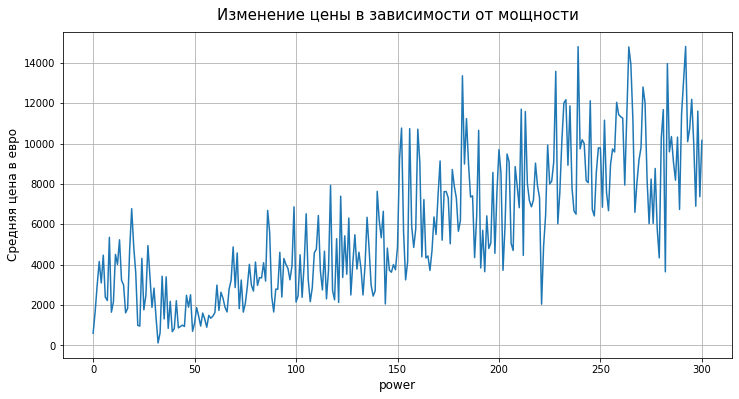

In [36]:
price_plot('power', 'Изменение цены в зависимости от мощности')

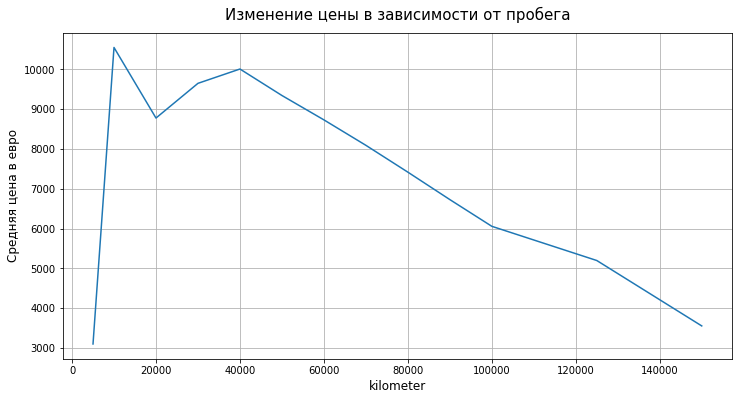

In [37]:
price_plot('kilometer', 'Изменение цены в зависимости от пробега')

### 2.3 Корреляция

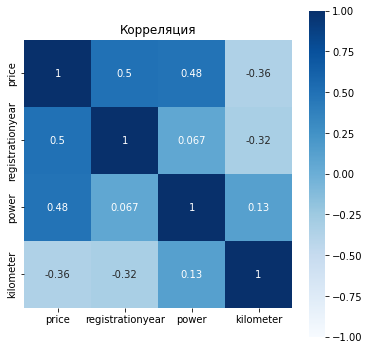

In [38]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, annot=True, square=True, vmin=-1, vmax=1, cmap="Blues")
plt.title('Корреляция')
plt.show()

Прослеживается заметная корреляция таргета с годом регистрации и мощностью, умеренная корреляция таргета с пробегом и  умеренная корреляция между пробегом и годом регистрации, в остальных случаях корреляция слабая или ее нет совсем. (Руководствовался шкалой Чеддока)

## 3. Обучение моделей

Фичи:
1) Object:
* vehicletype, registrationyear, gearbox, model, fueltype, brand, notrepaired.

2) Int:
* power, kilometer.
    
Таргет:
* price

### 3.1 Разделение и кодирование выборок

In [39]:
df_ohe = df.copy()
df_ohe['registrationyear'] = df_ohe['registrationyear'].astype(str)
df_ohe = pd.get_dummies(df_ohe)

df_light = df.copy()
df_light = df_light.astype(
    {"vehicletype":'category', 
     "registrationyear":'category',
     "gearbox":'category', 
     "model":'category',
     "fueltype":'category',
     "brand":'category',
     'notrepaired':'category',}
)

df_oe = df_light

In [40]:
(trainX_wo_ohe,
 testX_wo_ohe,
 trainY_wo_ohe,
 testY_wo_ohe,) = train_test_split(df.drop(['price'], axis=1),
                                   df['price'],
                                   test_size=0.25,
                                   random_state=RND) 

(trainX_wo_ohe_light,
 testX_wo_ohe_light,
 trainY_wo_ohe_light,
 testY_wo_ohe_light,) = train_test_split(df_light.drop(['price'], axis=1),
                                         df_light['price'],
                                         test_size=0.25,
                                         random_state=RND) 

In [41]:
del df_light, df

### 3.2 LightGBM

In [42]:
%%time

cats_cols=['vehicletype', 'registrationyear', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

model = LGBMRegressor()
params = {
    'metric': ['l2'],
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100],
    'max_depth' : [5, 7, 10],
    'random_state' : [RND],
    'force_col_wise': [True],
    'num_leaves' : [128],
}
    
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(trainX_wo_ohe_light, trainY_wo_ohe_light)
lgb_params = grid_cv.best_params_
print('Best hyperparams: ', grid_cv.best_params_)
print(f'RMSE score on train sample: {round((-grid_cv.best_score_) ** 0.5, 3)}\n')

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'metric': 'l2', 'n_estimators': 100, 'num_leaves': 128, 'random_state': 2102}
RMSE score on train sample: 1623.023

CPU times: total: 26.3 s
Wall time: 10.5 s


In [43]:
%%time

model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(trainX_wo_ohe_light, trainY_wo_ohe_light)
predict_lgb = model_lgb.predict(testX_wo_ohe_light)
print(f'Test RMSE = {round(mse(testY_wo_ohe_light, predict_lgb)**0.5, 3)}')

Test RMSE = 1606.584
CPU times: total: 31 s
Wall time: 1.32 s


### 3.3 Catboost

In [44]:
%%time

model = CatBoostRegressor()
params = {
    'n_estimators' : [50, 100],
    'random_state' : [RND],
    'max_depth' : [5, 7, 10],
    'verbose':[0]
}
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(trainX_wo_ohe, trainY_wo_ohe, cat_features=cats_cols)
catb_params = grid_cv.best_params_
print('Best hyperparams: ', grid_cv.best_params_)
print(f'RMSE score on train sample: {round((-grid_cv.best_score_) ** 0.5, 3)}\n')

Best hyperparams:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 2102, 'verbose': 0}
RMSE score on train sample: 1669.798

CPU times: total: 1min 4s
Wall time: 39.2 s


In [45]:
%%time

catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(trainX_wo_ohe, trainY_wo_ohe, cat_features=cats_cols)
catb_pred = catb_model.predict(testX_wo_ohe)
print(f'Test RMSE = {round(mse(testY_wo_ohe_light, predict_lgb)**0.5, 3)}')

Test RMSE = 1606.584
CPU times: total: 1min 3s
Wall time: 7.3 s


### 3.4 Simpleboost (ohe)

In [46]:
%%time

n = 100
nu = 0.1
trees = []

train_ohe = df_ohe[:int(len(df_ohe.index)/4 * 3)]
test_ohe = df_ohe[int(len(df_ohe.index)/4 * 3):]
train_ohe['y_pred'] = train_ohe['price'].mean()

for i in trange(n):
    train_ohe['residual'] = train_ohe['price'] - train_ohe['y_pred']
    tree = DecisionTreeRegressor(max_depth=10)
    tree.fit(train_ohe.drop(['y_pred', 'residual', 'price'], axis=1), train_ohe['residual'])
    train_ohe['y_pred'] += nu * tree.predict(train_ohe.drop(['y_pred', 'residual', 'price'], axis=1))
    trees.append(tree)
    
print(f'RMSE score on train sample: {round(mse(train_ohe["price"], train_ohe["y_pred"]) ** 0.5, 3)}\n')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:54<00:00,  5.34s/it]

RMSE score on train sample: 1483.386

CPU times: total: 8min 54s
Wall time: 8min 54s


In [47]:
%%time

test_ohe['y_pred'] = test_ohe['price'].mean()

for tree in trees:
    test_ohe['y_pred'] += nu * tree.predict(test_ohe.drop(['y_pred', 'price'], axis=1))

print(f'Test RMSE = {round(mse(test_ohe["price"], test_ohe["y_pred"]) ** 0.5, 3)}\n')

Test RMSE = 1734.115

CPU times: total: 17.6 s
Wall time: 17.7 s


### 3.5 RandomForest (ohe)

In [48]:
%%time

RF = RandomForestRegressor(criterion = "mse", random_state=RND, n_estimators = 100, n_jobs=-1)
RF.fit(train_ohe.drop(['y_pred', 'residual', 'price'], axis=1), train_ohe['price'])

print(f'RMSE score on train sample: {round(mse(train_ohe["price"], RF.predict(train_ohe.drop(["y_pred", "residual", "price"], axis=1))) ** 0.5, 3)}\n')

RMSE score on train sample: 1040.796

CPU times: total: 54min 18s
Wall time: 2min 25s


In [49]:
%%time

print(f'Test RMSE = {round(mse(test_ohe["price"], RF.predict(test_ohe.drop(["y_pred", "price"], axis=1))) ** 0.5, 3)}\n')

Test RMSE = 1768.556

CPU times: total: 12.1 s
Wall time: 741 ms


### 3.6 Simpleboost (oe)

In [50]:
for cat in cats_cols:
    df_oe[cat] = df_oe[cat].cat.codes

In [51]:
df_oe

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,4,1,1,90,116,150000,6,38,0
1,18300,2,19,1,190,29,125000,2,1,1
2,9800,6,12,0,163,117,125000,2,14,0
3,1500,5,9,1,75,116,150000,6,38,0
4,3600,5,16,1,69,101,90000,2,31,0
...,...,...,...,...,...,...,...,...,...,...
268704,3200,4,12,1,225,140,150000,6,30,1
268705,2200,4,13,1,107,166,20000,6,33,0
268706,1199,1,8,0,101,106,125000,6,32,0
268707,9200,0,4,1,102,222,150000,2,38,0


In [52]:
%%time

n = 100
nu = 0.1
trees = []

train_oe = df_ohe[:int(len(df_oe.index)/4 * 3)]
test_oe = df_ohe[int(len(df_oe.index)/4 * 3):]
train_oe['y_pred'] = train_oe['price'].mean()

for i in trange(n):
    train_oe['residual'] = train_oe['price'] - train_oe['y_pred']
    tree = DecisionTreeRegressor(max_depth=10)
    tree.fit(train_oe.drop(['y_pred', 'residual', 'price'], axis=1), train_oe['residual'])
    train_oe['y_pred'] += nu * tree.predict(train_oe.drop(['y_pred', 'residual', 'price'], axis=1))
    trees.append(tree)
    
print(f'RMSE score on train sample: {round(mse(train_oe["price"], train_oe["y_pred"]) ** 0.5, 3)}\n')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:59<00:00,  5.39s/it]

RMSE score on train sample: 1484.68

CPU times: total: 8min 59s
Wall time: 8min 59s


In [53]:
%%time

test_oe['y_pred'] = test_oe['price'].mean()

for tree in trees:
    test_oe['y_pred'] += nu * tree.predict(test_oe.drop(['y_pred', 'price'], axis=1))

print(f'Test RMSE = {round(mse(test_oe["price"], test_oe["y_pred"]) ** 0.5, 3)}\n')

Test RMSE = 1734.182

CPU times: total: 18.7 s
Wall time: 18.7 s


### 3.7 RandomForest (oe)

In [54]:
%%time

RF = RandomForestRegressor(criterion = "mse", random_state=RND, n_estimators = 100, n_jobs=-1)
RF.fit(train_oe.drop(['y_pred', 'residual', 'price'], axis=1), train_oe['price'])

print(f'RMSE score on train sample: {round(mse(train_oe["price"], RF.predict(train_oe.drop(["y_pred", "residual", "price"], axis=1))) ** 0.5, 3)}\n')

RMSE score on train sample: 1040.796

CPU times: total: 54min 25s
Wall time: 2min 26s


In [55]:
%%time

print(f'Test RMSE = {round(mse(test_oe["price"], RF.predict(test_oe.drop(["y_pred", "price"], axis=1))) ** 0.5, 3)}\n')

Test RMSE = 1768.556

CPU times: total: 12 s
Wall time: 731 ms


### 3.8 ohe vs oe

In [58]:
results = {
    'Model' : ['RandomForest (ohe)','RandomForest (oe)', 'Simpleboost (ohe)', 'Simpleboost (oe)'],
    'Train RMSE' :pd.Series([1040.796, 1040.796, 1483.386, 1484.68]),
    'Test RMSE' :pd.Series([1768.556, 1768.556, 1734.115, 1734.182]),
    'Train Time, sec': pd.Series(['2 м. 25 сек.', '2 м. 26 сек.', '8 м. 54 сек.', '8 м. 59 сек.']),
    'Test Time, sec': pd.Series(['741 мс', '731 мс.', '17.7 сек.', '18.7 сек.']),
    }

display(pd.DataFrame(results))

,Model,Train RMSE,Test RMSE,"Train Time, sec","Test Time, sec"
0,RandomForest (ohe),1040.796,1768.556,2 м. 25 сек.,741 мс
1,RandomForest (oe),1040.796,1768.556,2 м. 26 сек.,731 мс.
2,Simpleboost (ohe),1483.386,1734.115,8 м. 54 сек.,17.7 сек.
3,Simpleboost (oe),1484.680,1734.182,8 м. 59 сек.,18.7 сек.


**Итог:**
* При использовании `ohe` с `RandomForest` модель обучилась на 1 сек. быстрее
* При использовании `ohe` с `Simpleboost` модель обучилась на 5 сек быстрее

Время обучения/предсказания не должно зависить от кодирования признаков, а получившийся разброс Simpleboost получился из-за того, что я не использовал `random_seed`.

На мой взгляд, у прямого кодирования преимущество только в том, что он работает со всеми моделями, в том числе подходит и для логистической регрессии, когда все признаки должны стать количественными.

## 4. Анализ моделей

Мы провели анализ и обработку данных. Подготовили их и обучили модели на их основе. Нашли лучшие гиперпараметры для моделей и протестировали их на тестовой выборке, применив метрику RMSE.



In [56]:
results = {
    'Model' : ['LightGBM', 'Catboost', 'RandomForest','Simpleboost'],
    'Train RMSE' :pd.Series([1623.023, 1669.798, 1040.796, 1483.384]),
    'Test RMSE' :pd.Series([1606.584, 1606.584, 1768.556, 1733.33]),
    'Train Time, sec': pd.Series(['10.4 сек.', '39 сек.', '2 м. 24 сек.', '8 м. 56 сек.']),
    'Test Time, sec': pd.Series(['1.35 сек', '7.16 сек.', '817 мс.', '17.8 сек.']),
    }
display(pd.DataFrame(results))

,Model,Train RMSE,Test RMSE,"Train Time, sec","Test Time, sec"
0,LightGBM,1623.023,1606.584,10.4 сек.,1.35 сек
1,Catboost,1669.798,1606.584,39 сек.,7.16 сек.
2,RandomForest,1040.796,1768.556,2 м. 24 сек.,817 мс.
3,Simpleboost,1483.384,1733.330,8 м. 56 сек.,17.8 сек.


Исходя из полученных результатов можно сделать вывод:
* Все рассмотренные модели преодолели порог в 2500.
* Наименьшую ошибку на тесте выдают `CatBoost` и `LightGBM`.
* `LightGBM` самая лучшая модель из всех (по скорости и по скору).
* Похоже `RandomForest` и `Simpleboost` переобучились на тренировочной выборке, но показили примерно похожий скор на тесте
* `Simpleboost` самая долгая модель из всех.

Основываясь на этом, можно сделать вывод, что лучше всего подойдет модель построенная на `LightGBM`